Import libraries

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
from torch.nn import functional as F
import math

import time
import neurogym as ngym

In [ ]:
import matplotlib.pyplot as plt # type: ignore
import scienceplots # type: ignore
plt.style.use('science')
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
# parameters for the science style -- too many 
plt.style.use(['science','no-latex'])
plt.rcParams.update({
    "font.size": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.linewidth": 1,
    "axes.edgecolor": "black",
    "legend.fancybox": True,
    "legend.frameon": True,
    "legend.edgecolor": "black",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.color": "#b7b7b7",
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
})

## NeuroGym Task 1

In [4]:
task_name = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

In [5]:
# Make supervised dataset
seq_len = 100
batch_size = 16
#Create the dataset (Hover over ngym.Dataset to see input arguments)
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, seq_len=seq_len, batch_size=batch_size)
env = dataset.env

# Generate one batch of data when called
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

Input has shape (SeqLen, Batch, Dim) = torch.Size([100, 16, 3])
Target has shape (SeqLen, Batch) = (100, 16)


### Define Training Model

In [6]:
def train_model(net, dataset, criterion, model = None, return_train = False, steps_num = 2000):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair
        criterion: a pytorch loss function
        model: a model object that is used in the loss function

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    
    # Initialize the lists to store the loss and steps
    steps = []
    losses = []

    running_loss = 0
    running_acc = 0
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(steps_num):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        if model == None:
            loss = criterion(output, labels)
        else:
            loss = criterion(output, labels, model)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            

            # Append the loss and step
            steps.append(i+1)
            losses.append(running_loss)

            running_loss = 0

    # Return the trained network
    if return_train:
        return net, steps, losses
    else:
        return net

### Brian like penalties for cost function

In [7]:
# define penalties
def sparsity_penalty(model, beta_sparsity=0.5):
    """Compute sparsity penalty based on the model's weights."""
    return beta_sparsity * torch.sum(torch.abs(model.fc.weight))

def firing_rate_penalty(output, beta_firing_rate=0.5):
    """Compute penalty for high firing rates based on the model's output."""
    return beta_firing_rate * torch.sum(torch.square(output))


# define loss function
def loss_brain_penalties(output, target, model, 
                                beta_sparsity=0.05, beta_firing_rate=0.5):
    """
    Compute the total loss with added penalties for sparsity, firing rate, and long-distance connections.
    """
    # Base task-specific loss - same as before
    loss = nn.CrossEntropyLoss()(output, target)

    # Add penalties
    total_loss = loss
    total_loss += sparsity_penalty(model, beta_sparsity)
    total_loss += firing_rate_penalty(output, beta_firing_rate)
    
    return total_loss

## Model 1: Leaky RNN (from notes)

In [8]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))

        #implement how much the previous hidden layer activity should be maintained in the new activity
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add a Linear output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

### No penalty

In [9]:
# Instantiate the network and print information
hidden_size = 128
criterion = nn.CrossEntropyLoss()

# Create an instance of the Class RNNNet
net = RNNNet(input_size, hidden_size, output_size, dt=env.dt)
print(net)

net, m1_np_s, m1_np_l = train_model(net, dataset, criterion, return_train=True)

RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.3654, Time 3.0s
Step 200, Loss 0.0946, Time 6.1s
Step 300, Loss 0.0535, Time 9.0s
Step 400, Loss 0.0414, Time 12.0s
Step 500, Loss 0.0331, Time 15.0s
Step 600, Loss 0.0336, Time 17.9s
Step 700, Loss 0.0349, Time 21.0s
Step 800, Loss 0.0309, Time 24.0s
Step 900, Loss 0.0316, Time 27.2s
Step 1000, Loss 0.0297, Time 30.3s
Step 1100, Loss 0.0280, Time 33.4s
Step 1200, Loss 0.0261, Time 36.5s
Step 1300, Loss 0.0264, Time 39.6s
Step 1400, Loss 0.0278, Time 42.8s
Step 1500, Loss 0.0278, Time 46.0s
Step 1600, Loss 0.0237, Time 49.0s
Step 1700, Loss 0.0258, Time 52.2s
Step 1800, Loss 0.0249, Time 55.4s
Step 1900, Loss 0.0243, Time 58.6s
Step 2000, Loss 0.0246, Time 62.0s


### Sparsity penalty

In [10]:
# Create an instance of the Class RNNNet
net = RNNNet(input_size, hidden_size, output_size, dt=env.dt) # same as before

net, m1_sp_s, m1_sp_l = train_model(
    net, 
    dataset, 
    lambda output, target, model: loss_brain_penalties(output, target, model, beta_sparsity=0.5, beta_firing_rate=0),
    model=net,  # pass for penalty calc
    return_train=True
)


Training network...
Step 100, Loss 1.2787, Time 3.2s
Step 200, Loss 0.6281, Time 6.5s
Step 300, Loss 0.6103, Time 9.8s
Step 400, Loss 0.6066, Time 12.9s
Step 500, Loss 0.5744, Time 16.1s
Step 600, Loss 0.5718, Time 19.4s
Step 700, Loss 0.5701, Time 22.7s
Step 800, Loss 0.5745, Time 25.8s
Step 900, Loss 0.5733, Time 29.1s
Step 1000, Loss 0.5720, Time 32.3s
Step 1100, Loss 0.5749, Time 35.5s
Step 1200, Loss 0.5733, Time 38.7s
Step 1300, Loss 0.5707, Time 42.1s
Step 1400, Loss 0.5755, Time 45.3s
Step 1500, Loss 0.5926, Time 48.7s
Step 1600, Loss 0.5710, Time 52.0s
Step 1700, Loss 0.5719, Time 55.2s
Step 1800, Loss 0.5726, Time 58.6s
Step 1900, Loss 0.5677, Time 62.2s
Step 2000, Loss 0.5715, Time 65.5s


### Low Firing Rate Penalty

In [11]:
# Create an instance of the Class RNNNet
net = RNNNet(input_size, hidden_size, output_size, dt=env.dt) # same as before

net, m1_lfr_s, m1_lfr_l = train_model(
    net, 
    dataset, 
    lambda output, target, model: loss_brain_penalties(output, target, model, beta_sparsity=0, beta_firing_rate=0.5),
    model=net,  # pass for penalty calc
    return_train=True
)

Training network...
Step 100, Loss 7.8351, Time 3.7s
Step 200, Loss 1.1280, Time 7.1s
Step 300, Loss 1.1137, Time 10.4s
Step 400, Loss 1.1079, Time 13.7s
Step 500, Loss 1.1051, Time 17.0s
Step 600, Loss 1.1035, Time 20.3s
Step 700, Loss 1.1024, Time 23.8s
Step 800, Loss 1.1017, Time 27.2s
Step 900, Loss 1.1010, Time 31.0s
Step 1000, Loss 1.1006, Time 34.7s
Step 1100, Loss 1.1002, Time 38.2s
Step 1200, Loss 1.0999, Time 41.5s
Step 1300, Loss 1.0997, Time 44.9s
Step 1400, Loss 1.0996, Time 48.3s
Step 1500, Loss 1.0994, Time 51.8s
Step 1600, Loss 1.0993, Time 55.2s
Step 1700, Loss 1.0992, Time 58.9s
Step 1800, Loss 1.0992, Time 63.2s
Step 1900, Loss 1.0991, Time 67.0s
Step 2000, Loss 1.0990, Time 70.8s


# Model EI 

In [12]:
class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        #First create a mask to remove the diagonal (matrix size hidden_size*hidden_size)
        mask_no_diag = torch.ones((hidden_size, hidden_size)) - torch.eye(hidden_size)
        # Define the excitatory an inhibitory units with columns of 1s and -1s (use e_size and i_size)
        E_I_unit_list = np.concatenate([np.ones(self.e_size), -np.ones(self.i_size)]).T

        mask = torch.tensor(E_I_unit_list, dtype=torch.float32) * mask_no_diag

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)


In [13]:
class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

In [14]:
class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

### No penalty

In [15]:
# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

criterion = nn.CrossEntropyLoss()
net, m2_np_s, m2_np_l = train_model(net, dataset, criterion, return_train=True)

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Training network...


C:\Users\alejo\AppData\Local\Temp\ipykernel_32176\3936818147.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


Step 100, Loss 0.2833, Time 4.0s
Step 200, Loss 0.0810, Time 8.0s
Step 300, Loss 0.0476, Time 12.4s
Step 400, Loss 0.0369, Time 18.7s
Step 500, Loss 0.0318, Time 24.3s
Step 600, Loss 0.0310, Time 30.8s
Step 700, Loss 0.0310, Time 36.2s
Step 800, Loss 0.0293, Time 41.6s
Step 900, Loss 0.0279, Time 45.9s
Step 1000, Loss 0.0309, Time 49.9s
Step 1100, Loss 0.0285, Time 54.0s
Step 1200, Loss 0.0283, Time 58.3s
Step 1300, Loss 0.0268, Time 62.3s
Step 1400, Loss 0.0275, Time 66.3s
Step 1500, Loss 0.0248, Time 70.4s
Step 1600, Loss 0.0235, Time 74.4s
Step 1700, Loss 0.0250, Time 78.7s
Step 1800, Loss 0.0254, Time 83.2s
Step 1900, Loss 0.0258, Time 87.5s
Step 2000, Loss 0.0261, Time 92.1s


### Sparsity Penalty

In [16]:
# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

criterion = nn.CrossEntropyLoss()
net, m2_sp_s, m2_sp_l = train_model(net, 
    dataset, 
    lambda output, target, model: loss_brain_penalties(output, target, model, beta_sparsity=0.5, beta_firing_rate=0),
    model=net,  # pass for penalty calc
    return_train=True
)

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Training network...


C:\Users\alejo\AppData\Local\Temp\ipykernel_32176\3936818147.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


Step 100, Loss 1.0113, Time 4.7s
Step 200, Loss 0.4809, Time 8.8s
Step 300, Loss 0.4473, Time 13.0s
Step 400, Loss 0.4198, Time 17.0s
Step 500, Loss 0.3786, Time 21.2s
Step 600, Loss 0.3529, Time 25.6s
Step 700, Loss 0.3389, Time 29.8s
Step 800, Loss 0.3392, Time 33.9s
Step 900, Loss 0.3340, Time 37.8s
Step 1000, Loss 0.3306, Time 41.8s
Step 1100, Loss 0.3324, Time 45.8s
Step 1200, Loss 0.3283, Time 49.8s
Step 1300, Loss 0.3227, Time 53.7s
Step 1400, Loss 0.3225, Time 57.7s
Step 1500, Loss 0.3151, Time 61.6s
Step 1600, Loss 0.3169, Time 65.6s
Step 1700, Loss 0.3088, Time 69.6s
Step 1800, Loss 0.3058, Time 73.6s
Step 1900, Loss 0.3007, Time 77.5s
Step 2000, Loss 0.2991, Time 81.4s


In [17]:
# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

criterion = nn.CrossEntropyLoss()
net, m2_lfr_s, m2_lfr_l = train_model(net, 
    dataset, 
    lambda output, target, model: loss_brain_penalties(output, target, model, beta_sparsity=0, beta_firing_rate=0.5),
    model=net,  # pass for penalty calc
    return_train=True
)

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Training network...


C:\Users\alejo\AppData\Local\Temp\ipykernel_32176\3936818147.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


Step 100, Loss 6.0097, Time 3.9s
Step 200, Loss 1.2881, Time 7.9s
Step 300, Loss 1.1450, Time 11.8s
Step 400, Loss 1.1119, Time 15.8s
Step 500, Loss 1.1046, Time 19.8s
Step 600, Loss 1.1027, Time 23.7s
Step 700, Loss 1.1019, Time 27.7s
Step 800, Loss 1.1013, Time 31.6s
Step 900, Loss 1.1009, Time 35.4s
Step 1000, Loss 1.1006, Time 39.3s
Step 1100, Loss 1.1001, Time 43.4s
Step 1200, Loss 1.1000, Time 47.2s
Step 1300, Loss 1.0997, Time 51.1s
Step 1400, Loss 1.0995, Time 55.2s
Step 1500, Loss 1.0994, Time 59.1s
Step 1600, Loss 1.0993, Time 63.0s
Step 1700, Loss 1.0992, Time 66.9s
Step 1800, Loss 1.0991, Time 70.8s
Step 1900, Loss 1.0990, Time 74.8s
Step 2000, Loss 1.0989, Time 78.9s


## Plot

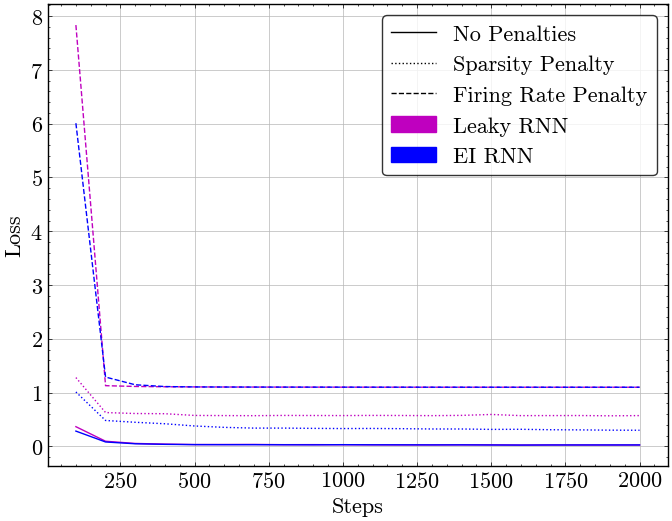

In [35]:
# create fig
plt.figure(figsize=(8, 6))

# define colours
leaky_rnn_color = 'm'  
ei_rnn_color = 'b'  

# define lines
line_styles = {
    'No Penalties': '-',  
    'Sparsity Penalty': ':',  
    'Firing Rate Penalty': '--',  
}


# leaky RNN (m1)
plt.plot(m1_np_s, m1_np_l, color=leaky_rnn_color, linestyle=line_styles['No Penalties'])
plt.plot(m1_sp_s, m1_sp_l, color=leaky_rnn_color, linestyle=line_styles['Sparsity Penalty'])
plt.plot(m1_lfr_s, m1_lfr_l, color=leaky_rnn_color, linestyle=line_styles['Firing Rate Penalty'])

# EI RNN (m2)
plt.plot(m2_np_s, m2_np_l, color=ei_rnn_color, linestyle=line_styles['No Penalties'])
plt.plot(m2_sp_s, m2_sp_l, color=ei_rnn_color, linestyle=line_styles['Sparsity Penalty'])
plt.plot(m2_lfr_s, m2_lfr_l, color=ei_rnn_color, linestyle=line_styles['Firing Rate Penalty'])

# custom legend
legend_elements = [
    mlines.Line2D([], [], color='k', linestyle=line_styles['No Penalties'], label='No Penalties'),
    mlines.Line2D([], [], color='k', linestyle=line_styles['Sparsity Penalty'], label='Sparsity Penalty'),
    mlines.Line2D([], [], color='k', linestyle=line_styles['Firing Rate Penalty'], label='Firing Rate Penalty'),
    mpatches.Patch(color=leaky_rnn_color, label='Leaky RNN'),
    mpatches.Patch(color=ei_rnn_color, label='EI RNN')
]

plt.xlabel('Steps')
plt.ylabel('Loss')

# add legend
plt.legend(handles=legend_elements)

# Show plot
plt.show()

